In [ ]:
import os
import pandas as pd
import numpy as np
from typing import Union, List, Literal, Dict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
from Helper_Util import *

In [ ]:
Filepath = '/content/drive/MyDrive/QoS Prediction Challenge by ITU ML in 5G Challenge'
pd.set_option('display.max_colwidth',200)

In [ ]:
def Load_Data(file_path: str) -> List[pd.DataFrame]:
  train = pd.read_csv(file_path+'/Train.csv')
  test = pd.read_csv(file_path+'/Test.csv')
  sub = pd.read_csv(file_path+'/SampleSubmission.csv')
  variables = pd.read_csv(file_path+'/VariableDefinitions.csv')

  return train, test, sub, variables


In [ ]:
Train, Test, Sub, Variables = Load_Data(Filepath)

### Data Exploration

In [ ]:
Train.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


In [ ]:
Test.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area
0,Id_ln0e0hfrgx,1624374179,pc2,-97.121875,-12.923750,-87.554375,13.293,39276.0,24.0,20,...,23.05,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,3.07702,Avenue
1,Id_svf7nz9fxv,1624366264,pc4,-65.202500,-9.944375,-35.501875,21.823,39566.0,25.0,20,...,21.56,13.92,0.62,1013.6,2.42,0.95,4.0,16.093,0.66000,Park
2,Id_ww2mh07gwj,1624375795,pc2,-79.298125,-17.468750,-74.823750,24.114,41900.0,27.0,20,...,22.93,14.65,0.60,1013.5,2.26,0.85,3.0,16.093,2.49330,Park


In [ ]:
Train.select_dtypes(include=['object']).columns
Test.select_dtypes(include=['object']).columns

Index(['id', 'device', 'area'], dtype='object')

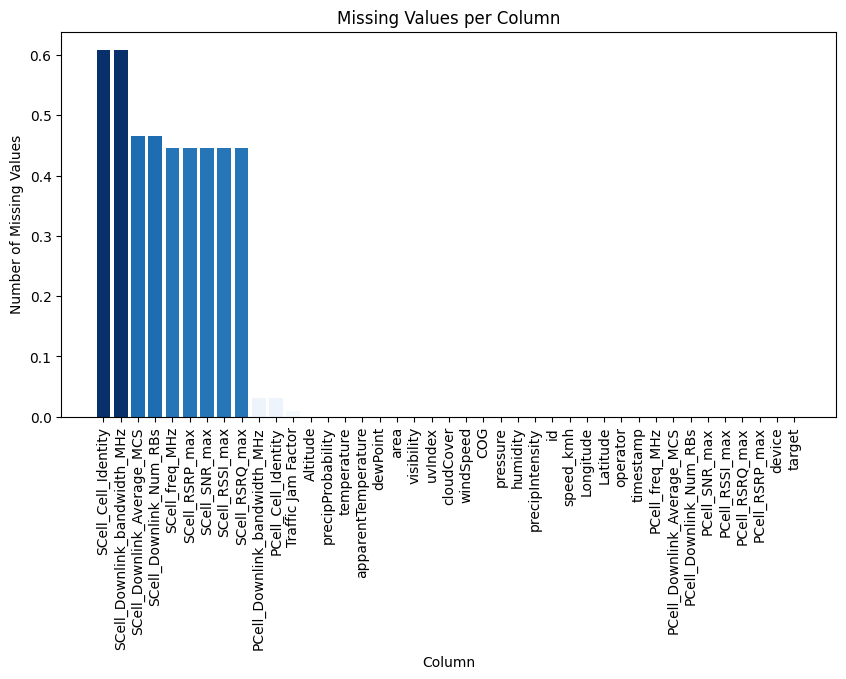

In [ ]:
missing_values = Train.isna().sum()/ Train.shape[0]
missing_values = missing_values.sort_values(ascending=False)


# Normalize the data to be between 0 and 1
norm = plt.Normalize(missing_values.values.min(), missing_values.values.max())
# Create a colormap
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
# Generate colors for each bar
colors = [cmap.to_rgba(val) for val in missing_values.values]

# Create bar plot of missing values
plt.figure(figsize=(10,5))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.show()



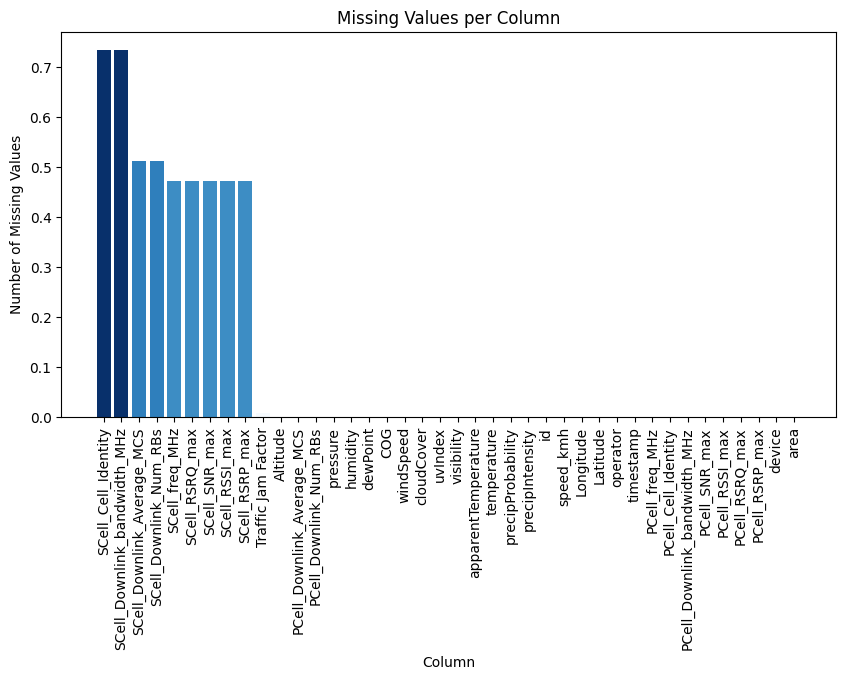

In [ ]:
missing_values = Test.isna().sum()/ Test.shape[0]
missing_values = missing_values.sort_values(ascending=False)
import matplotlib.cm as cm

# Normalize the data to be between 0 and 1
norm = plt.Normalize(missing_values.values.min(), missing_values.values.max())
# Create a colormap
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
# Generate colors for each bar
colors = [cmap.to_rgba(val) for val in missing_values.values]

# Create bar plot of missing values
plt.figure(figsize=(10,5))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.show()

SCELLS_ have the most missing values

###Baseline Score

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, Dataset, early_stopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from abc import ABC, abstractmethod
import random

In [ ]:
!pip install catboost -q
from catboost import CatBoostRegressor, Pool

In [ ]:
Sscaler = StandardScaler()
Mmscaler = MinMaxScaler()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
cbc = CatBoostRegressor(eval_metric='RMSE',learning_rate=0.08,depth=9)
lgb = LGBMRegressor()
mse = mean_squared_error

In [ ]:
class Baseline_score():
  def __init__(
      self,
      train: pd.DataFrame,
      model: Union[XGBRegressor, LGBMRegressor, CatBoostRegressor,RandomForestRegressor],
      scaler: Union[StandardScaler, MinMaxScaler, None] = None,
      split_method: Literal["KFold", "train_test_split"] = "KFold",
      return_baseline: Literal[True, False] = True,
      num_split = 5,
      random_seed = 42,
      VERBOSE: int = 0
  ):
    if not isinstance(model, (XGBRegressor, LGBMRegressor, CatBoostRegressor,RandomForestRegressor)):
      raise TypeError("model must be a class of either XGBRegressor, LGBMRegressor, CatBoostRegressor, or LinearRegression")
    if scaler is not None and not isinstance(scaler, (StandardScaler, MinMaxScaler)):
        raise TypeError("scaler must be a class of either StandardScaler, MinMaxScaler or None")
    if not isinstance(train, pd.DataFrame):
      raise TypeError("train must be a DataFrame")

    self.train = train
    self.model = model
    self.scaler = scaler
    self.split = split_method
    self.num_split = num_split
    self.seed = random_seed
    self.return_baseline = return_baseline
    self.VERBOSE = VERBOSE
    self.feature_importances = None
    self.bsv = {}
    random.seed(random_seed)
    np.random.seed(random_seed)

  def run(self)-> float:
    X = self.train.iloc[:,:-1]
    self.feature_importances = np.zeros(X.shape[1])
    y = self.train.iloc[:,-1]

    if self.split == "train_test_split":
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=self.seed)

      if self.scaler != None:
        X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

      if isinstance(self.model, LGBMRegressor):
        self.model.fit(X_train, y_train, eval_set=(X_test, y_test), callbacks=[early_stopping(stopping_rounds=100)], verbose=self.VERBOSE)

      elif isinstance(self.model, CatBoostRegressor):
        self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

      elif isinstance(self.model, XGBRegressor):
        self.model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=20,verbose=self.VERBOSE)

      else:
        self.model.fit(X_train,y_train)

      self.feature_importances += self.model.feature_importances_
      if isinstance(self.model, XGBRegressor):
        results = self.model.evals_result()
        evals_result = self.model.evals_result()
        best_scores = {}
        for metric in self.model.eval_metric:
          best_scores[metric] = min(evals_result['validation_0'][metric])
        for metric, score in best_scores.items():
          print(f"Best {metric}: {score}")
      else:
        results = self.model.best_score_
      preds = self.model.predict(X_test)
      train_baseline = self.model.predict(X)
      self.bsv.update({'train':train_baseline})

      if self.VERBOSE > 0:
        print(f"split: {(self.split).upper()}")
        print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
        print(f"Model RMSE: {results.values()}")

      score = mean_squared_error(y_test,preds,squared=False)

      if self.return_baseline:
        return score, self.bsv

      return score

    else:
      fold = KFold(n_splits=self.num_split)
      oof_f1 = []
      i = 1
      for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]

        if self.scaler != None:
          X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

        if isinstance(self.model, LGBMRegressor):
          self.model.fit(X_train, y_train, eval_set=(X_test, y_test),callbacks=[early_stopping(stopping_rounds=20)],verbose=self.VERBOSE)

        elif isinstance(self.model, CatBoostRegressor):
          self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

        elif isinstance(self.model, XGBRegressor):
          self.model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=20,verbose=self.VERBOSE)

        else:
          self.model.fit(X_train,y_train)

        self.feature_importances += self.model.feature_importances_
        results = self.model.best_score_
        preds=self.model.predict(X_test)
        train_baseline = self.model.predict(X)
        self.bsv.update({f'{self.split}{i}train':train_baseline})

        if self.VERBOSE > 0:
          print(f"split {self.split}{i}")
          print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
          print(f"Model RMSE: {results.values()}")
        oof_f1.append(mean_squared_error(y_test,preds,squared=False))
        i += 1

      self.feature_importances = self.feature_importances / self.num_split
      score = sum(oof_f1)/self.num_split

      if self.return_baseline:
        return score, self.bsv

      return score

  def plot_features(self, n_features=20):
    X = self.train.iloc[:,:-1]
    features = pd.DataFrame({'feature': list(X.columns),
                             'importance': self.feature_importances}).sort_values('importance', ascending = True)
    norm = plt.Normalize(features['importance'][:n_features].min(), features['importance'][:n_features].max())
    cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
    colors = [cmap.to_rgba(val) for val in features['importance'][:n_features].values]
    plt.figure(figsize=(25,10))
    plt.barh(features['feature'][:n_features],features['importance'][:n_features], color=colors)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()




In [ ]:
class Baseline_predict(Baseline_score):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.preds = None

  def predict(self, test):
    X = self.train.iloc[:,:-1]
    y = self.train.iloc[:,-1]

    if self.split == "train_test_split":
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=self.seed)
      if self.scaler != None:
        X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

      if isinstance(self.model, LGBMRegressor):
        self.model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)], verbose=self.VERBOSE)

      elif isinstance(self.model, CatBoostRegressor):
        self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

      elif isinstance(self.model, XGBRegressor):
        self.model.fit(X_train,y_train, eval_set=(X_test,y_test), early_stopping_rounds=20,verbose=self.VERBOSE)

      else:
        self.model.fit(X_train,y_train)

      train_baseline = self.model.predict(test)
      self.bsv.update({'train':train_baseline})
      self.preds = self.model.predict(test)
      print(f"split: {(self.split).upper()}")

      if self.return_baseline:
        return self.preds, self.bsv

      return self.preds

    else:
      fold = KFold(n_splits=self.num_split)
      oof_preds = []
      i = 1
      for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]
        if self.scaler != None:
          X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

        if isinstance(self.model, LGBMRegressor):
          self.model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)], verbose=self.VERBOSE)

        elif isinstance(self.model, CatBoostRegressor):
          self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

        elif isinstance(self.model, XGBRegressor):
         self.model.fit(X_train,y_train, eval_set=(X_test,y_test), early_stopping_rounds=20,verbose=self.VERBOSE)

        else:
          self.model.fit(X_train,y_train)

        pred=self.model.predict(test)
        train_baseline = self.model.predict(test)
        self.bsv.update({f'{self.split}{i}train':train_baseline})
        if self.VERBOSE > 0:
          print(f"split {self.split}{i}")
        oof_preds.append(pred)
        i += 1

      self.preds = oof_preds

      if self.return_baseline:
        return self.preds, self.bsv

      return self.preds

  def submission(self, test):
    pres = self.preds
    if self.split == 'KFold':
      final_preds = sum(pres)/self.num_split
    else:
      final_preds = pres
    predictions_df = pd.DataFrame({'id': test.id, 'target': final_preds})
    return predictions_df




In [ ]:
TT = Train.drop(['id','device'],axis=1)
tests = Test.drop(['id','device'], axis=1)
#TT['device'] = TT['device'].map({'pc1':1,'pc3':2})
#TT['area'] = TT['area'].map({'Residential':1,'Avenue':2,'Park':3,'Highway':4,'Tunnel':5})
categorical_features = ['area']
oe = OrdinalEncoder()
tests['area'] = oe.fit_transform(tests[['area']])
TT['area'] = oe.fit_transform(TT[['area']])
tests.fillna(0, inplace=True)
TT.fillna(0, inplace=True)

In [ ]:
TT.head(3)

,timestamp,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,1624367008,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,26368258.0,1800.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,3.0,51500000.0
1,1624372465,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,2568970.0,1800.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,3.0,50300000.0
2,1624371871,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,2824458.0,1800.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,3.0,16500000.0


In [ ]:
TT_1 = TT.sample(frac=1)
TT_1.head(3)

,timestamp,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
28894,1624373796,-74.082500,-12.478125,-40.353750,21.533,38435.0,28.0,20.0,3428105.0,1800.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,8.05296,1.0,25600000.0
13917,1624542070,-97.730625,-15.350000,-62.291875,7.538,96188.0,14.0,20.0,26367489.0,1800.0,...,13.43,0.71,1017.9,1.97,0.99,3.0,16.093,8.80702,0.0,33200000.0
2663,1624354131,-81.581250,-10.125000,-53.066250,10.036,94606.0,19.0,20.0,30827264.0,1800.0,...,13.90,0.73,1012.2,4.23,0.97,4.0,16.093,2.61657,2.0,84600000.0


In [ ]:
TT_2 = TT.sample(frac=1)
TT_2.head(3)

,timestamp,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
16174,1624356228,-91.250625,-17.616250,-56.321875,0.817000,91118.0,19.0,20.0,40812803.0,1800.0,...,13.46,0.69,1012.5,4.09,0.96,4.0,16.093,3.14159,1.0,46000000.0
24901,1624374131,-76.191875,-12.397500,-45.368125,13.759000,46681.0,23.0,20.0,3499534.0,2600.0,...,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,4.50427,0.0,36800000.0
19241,1624552824,-86.796717,-13.160354,-55.238005,6.793939,11743.0,25.0,15.0,4051733.0,2000.0,...,13.80,0.73,1017.4,2.43,1.00,1.0,16.093,0.99534,3.0,2720000.0


In [ ]:
TT_3 = TT.sample(frac=1)
TT_3.head(3)

,timestamp,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
32537,1624348482,-76.865000,-13.8175,-46.056250,19.504,80969.0,26.0,20.0,33802242.0,1800.0,...,14.06,0.77,1011.9,4.07,0.97,3.0,16.093,2.99305,0.0,141000000.0
1107,1624373140,-85.646875,-12.2125,-52.740000,17.522,41521.0,25.0,20.0,2568970.0,1800.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.00946,3.0,59000000.0
10247,1624374198,-89.426250,-13.2775,-56.091875,9.816,32413.0,17.0,20.0,3499534.0,2600.0,...,14.55,0.59,1013.6,2.27,0.83,3.0,16.093,2.86572,0.0,12800000.0


In [ ]:
TT_4 = TT.sample(frac=1)
TT_4.head(3)

,timestamp,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
20275,1624552652,-67.468125,-13.708125,-32.853125,25.419,81888.0,28.0,0.0,0.0,1800.0,...,13.80,0.73,1017.4,2.43,1.00,1.0,16.093,3.16090,3.0,164000000.0
2336,1624377851,-91.986250,-12.253125,-59.430000,11.900,40137.0,19.0,20.0,3499534.0,2600.0,...,14.78,0.57,1013.7,2.21,0.76,2.0,16.093,2.38578,0.0,21200000.0
14864,1624365428,-97.362500,-15.338125,-61.638125,5.629,47635.0,13.0,20.0,26367489.0,1800.0,...,13.91,0.62,1013.6,2.41,0.95,4.0,16.093,2.82027,0.0,13900000.0


In [ ]:
cbc = CatBoostRegressor(loss_function='RMSE',custom_metric=['RMSE','MAE','Huber:delta=0.5'],learning_rate=0.08,depth=9,n_estimators=5000)
# cbc1 = CatBoostRegressor(learning_rate=0.08,eval_metric='RMSE',n_estimators=5000)

In [ ]:
Baseline = Baseline_score(train=TT,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=200,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

Baseline = Baseline_score(train=TT_1,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=200,random_seed=0)
lgb_score,bsv_2 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

Baseline = Baseline_score(train=TT_2,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=200,random_seed=0)
lgb_score,bsv_3 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

Baseline = Baseline_score(train=TT_3,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=200,random_seed=0)
lgb_score,bsv_4 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

Baseline = Baseline_score(train=TT_4,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=200,random_seed=0)
lgb_score,bsv_5 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

0:	learn: 40442650.1597919	test: 40441243.4452648	best: 40441243.4452648 (0)	total: 188ms	remaining: 15m 38s
200:	learn: 7864657.8762682	test: 9831207.3598372	best: 9831207.3598372 (200)	total: 15.2s	remaining: 6m 4s
400:	learn: 6484143.7447131	test: 9445960.8545335	best: 9445960.8545335 (400)	total: 24.4s	remaining: 4m 39s
600:	learn: 5692807.1389969	test: 9320480.4933492	best: 9320480.4933492 (600)	total: 35s	remaining: 4m 16s
800:	learn: 5112673.1114639	test: 9243319.7181046	best: 9243319.7181046 (800)	total: 45.7s	remaining: 3m 59s
1000:	learn: 4658555.7147118	test: 9201158.1505979	best: 9201158.1505979 (1000)	total: 54.4s	remaining: 3m 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 9186934.688
bestIteration = 1099

Shrink model to first 1100 iterations.
split KFold1
RMSE 9186934.688067216
Model RMSE: dict_values([{'Huber:delta=0.5': 1579839.4083854882, 'MAE': 3159679.0667699724, 'RMSE': 4433983.505169107}, {'Huber:delta=0.5': 2759037.675235765, 'MAE': 551807

In [ ]:
KFold_preds = pd.DataFrame(bsv_1).join(TT['target'])
KFold_preds_1 = pd.DataFrame(bsv_2).join(TT_1['target'].reset_index(drop=True))
KFold_preds_2 = pd.DataFrame(bsv_3).join(TT_2['target'].reset_index(drop=True))
KFold_preds_3 = pd.DataFrame(bsv_4).join(TT_3['target'].reset_index(drop=True))
KFold_preds_4 = pd.DataFrame(bsv_5).join(TT_4['target'].reset_index(drop=True))

In [ ]:
Baseline = Baseline_predict(train=TT,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_1,bsv_test1 = Baseline.predict(tests)


Baseline = Baseline_predict(train=TT_1,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_2,bsv_test2 = Baseline.predict(tests)


Baseline = Baseline_predict(train=TT_2,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_3,bsv_test3 = Baseline.predict(tests)


Baseline = Baseline_predict(train=TT_3,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_4,bsv_test4 = Baseline.predict(tests)


Baseline = Baseline_predict(train=TT_4,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_5,bsv_test5 = Baseline.predict(tests)


In [ ]:
test_preds = pd.DataFrame(bsv_test1)
test_preds_1 = pd.DataFrame(bsv_test2)
test_preds_2 = pd.DataFrame(bsv_test3)
test_preds_3 = pd.DataFrame(bsv_test4)
test_preds_4 = pd.DataFrame(bsv_test5)

In [ ]:
Baseline = Baseline_predict(train=KFold_preds,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_11,bsv_test11 = Baseline.predict(test_preds)


Baseline = Baseline_predict(train=KFold_preds_1,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_12,bsv_test12 = Baseline.predict(test_preds_1)


Baseline = Baseline_predict(train=KFold_preds_2,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_13,bsv_test13 = Baseline.predict(test_preds_2)


Baseline = Baseline_predict(train=KFold_preds_3,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_14,bsv_test14 = Baseline.predict(test_preds_3)


Baseline = Baseline_predict(train=KFold_preds_4,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict_15,bsv_test15 = Baseline.predict(test_preds_4)

In [ ]:
ensemble_pred = sum(predict_1)/5 + sum(predict_2)/5 + sum(predict_3)/5 + sum(predict_4)/5  + sum(predict_5)/5 + sum(predict_11)/5 + sum(predict_12)/5 + sum(predict_13)/5  + sum(predict_14)/5 + sum(predict_15)/5

In [ ]:
ensemble_pred/10

array([22962739.74011078, 61687235.422408  , 82657596.30170731, ...,
       20643754.58625842, 14300308.32036489, 33680426.76940422])

In [ ]:
predictions_df = pd.DataFrame({'id': Test.id, 'target': ensemble_pred/10})
predictions_df.to_csv('40th_sub.csv',index=False)

In [ ]:
Baseline = Baseline_score(train=TT_4,model=cbc,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

KFold_preds = pd.DataFrame(bsv_1)
KFold_preds = KFold_preds.join(TT_4['target'].reset_index(drop=True))

Baseline = Baseline_score(train=TT_4,model=cbc1,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
lgb_score,bsv_2 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

KFold_preds_1 = pd.DataFrame(bsv_2)
KFold_preds_1 = KFold_preds_1.join(TT_4['target'].reset_index(drop=True))

predictions = Baseline_predict(train=TT_4,model=cbc,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
predict_1,bsv_test1 = predictions.predict(tests)

predictions = Baseline_predict(train=TT_4,model=cbc1,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
predict_2,bsv_test2 = predictions.predict(tests)

testpreds_1 = pd.DataFrame(bsv_test1)
testpreds_2 = pd.DataFrame(bsv_test2)

predictions = Baseline_predict(train=KFold_preds,model=cbc,split_method='KFold',return_baseline=False,VERBOSE=0,random_seed=0)
predict_3 = predictions.predict(testpreds_1)

predictions = Baseline_predict(train=KFold_preds_1,model=cbc1,split_method='KFold',return_baseline=False,VERBOSE=0,random_seed=0)
predict_4 = predictions.predict(testpreds_2)

ensemble_pred = sum(predict_1)/15 + sum(predict_2)/15 + sum(predict_3)/5 + sum(predict_4)/5
final_preds = ensemble_pred/4

CV_RMSE_Score:9204054.26349729
CV_RMSE_Score:9180576.968995651


In [ ]:
Baseline = Baseline_score(train=TT_3,model=cbc,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

KFold_preds = pd.DataFrame(bsv_1)
KFold_preds = KFold_preds.join(TT_3['target'].reset_index(drop=True))

Baseline = Baseline_score(train=TT_3,model=cbc1,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
lgb_score,bsv_2 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

KFold_preds_1 = pd.DataFrame(bsv_2)
KFold_preds_1 = KFold_preds_1.join(TT_3['target'].reset_index(drop=True))

predictions = Baseline_predict(train=TT_3,model=cbc,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
predict_1,bsv_test1 = predictions.predict(tests)

predictions = Baseline_predict(train=TT_3,model=cbc1,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
predict_2,bsv_test2 = predictions.predict(tests)

testpreds_1 = pd.DataFrame(bsv_test1)
testpreds_2 = pd.DataFrame(bsv_test2)

predictions = Baseline_predict(train=KFold_preds,model=cbc,split_method='KFold',return_baseline=False,VERBOSE=0,random_seed=0)
predict_3 = predictions.predict(testpreds_1)

predictions = Baseline_predict(train=KFold_preds_1,model=cbc1,split_method='KFold',return_baseline=False,VERBOSE=0,random_seed=0)
predict_4 = predictions.predict(testpreds_2)

ensemble_pred = sum(predict_1)/15 + sum(predict_2)/15 + sum(predict_3)/5 + sum(predict_4)/5
final_preds_3 = ensemble_pred/4

CV_RMSE_Score:9170087.915600324
CV_RMSE_Score:9130755.388979923


###Data

In [ ]:
Test['target'] = 'Test'
data = pd.concat([Train,Test]).reset_index(drop=True)

###Data Visualization


In [ ]:
data.head(3)

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0


In [ ]:
Vard = Variables.set_index('VARIABLENAME').T

In [ ]:
Vard[data.filter(like="PCell").columns]

VARIABLENAME,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz
VARIABLE DESCRIPTION,Maximum reference signal received power in dBm from the primary cell,Maximum reference signal received quality in dB from the primary cell,Maximum received signal strength indicator in dBm from the primary cell,Maximum signal to noise ratio in dB from the primary cell,Aggregated number of received resource blocks in downlink from the primary cell,Average modulation and coding scheme weighted by received resource blocks from the primary cell,Downlink bandwidth in MHz from the primary cell,Cell ID of the primary cell,Carrier frequency in MHz of the primary cell


In [ ]:
data[['PCell_Downlink_Average_MCS','PCell_SNR_max','PCell_Downlink_Num_RBs']].describe()

In [ ]:
g = sns.PairGrid(data[['PCell_Downlink_Average_MCS','PCell_SNR_max','PCell_Downlink_Num_RBs']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [ ]:
scatterplot(x=Train['PCell_Downlink_Average_MCS'],y=Train['PCell_SNR_max'])

In [ ]:
g = sns.PairGrid(data[['PCell_Downlink_Average_MCS','PCell_RSRP_max','PCell_RSRQ_max','PCell_RSSI_max','PCell_SNR_max']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [ ]:
data[['PCell_RSRP_max','PCell_RSRQ_max','PCell_RSSI_max']].describe()

In [ ]:
data[['PCell_Downlink_Average_MCS','PCell_RSRP_max','PCell_RSRQ_max','PCell_RSSI_max','PCell_SNR_max']].head(3)

In [ ]:
data[['SCell_SNR_max','SCell_Downlink_Num_RBs','SCell_Cell_Identity','SCell_RSRQ_max']].describe()

In [ ]:
g = sns.PairGrid(data[['SCell_SNR_max','SCell_Downlink_Num_RBs','SCell_Cell_Identity','SCell_RSRQ_max']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

###Feature Engineering

In [ ]:
Variables

,VARIABLENAME,VARIABLE DESCRIPTION
0,id,Unique ID for each row
1,timestamp,Unix timestamp in seconds
2,device,ID of the vehicle carrying the UE
3,PCell_RSRP_max,Maximum reference signal received power in dBm from the primary cell
4,PCell_RSRQ_max,Maximum reference signal received quality in dB from the primary cell
5,PCell_RSSI_max,Maximum received signal strength indicator in dBm from the primary cell
6,PCell_SNR_max,Maximum signal to noise ratio in dB from the primary cell
7,PCell_Downlink_Num_RBs,Aggregated number of received resource blocks in downlink from the primary cell
8,PCell_Downlink_TB_Size,Aggregated transport block size in downlink from the primary cell
9,PCell_Downlink_Average_MCS,Average modulation and coding scheme weighted by received resource blocks from the primary cell


In [ ]:
data['N_PCell_RSRQ'] = data['PCell_RSRP_max'] / data['PCell_RSSI_max']
data['N_PCell_RSRP_Noise'] = data['PCell_RSRP_max'] / data['PCell_SNR_max']
data['N_PCell_RSRQ_Noise'] = data['PCell_RSRQ_max'] / data['PCell_SNR_max']
data['N_PCell_RSSI_Noise'] = data['PCell_RSSI_max'] / data['PCell_SNR_max']


In [ ]:
data['N_SCell_RSRQ'] = data['SCell_RSRP_max'] / data['SCell_RSSI_max']
data['N_SCell_RSRP_Noise'] = data['SCell_RSRP_max'] / data['SCell_SNR_max']
data['N_SCell_RSRQ_Noise'] = data['SCell_RSRQ_max'] / data['SCell_SNR_max']
data['N_SCell_RSSI_Noise'] = data['SCell_RSSI_max'] / data['SCell_SNR_max']

In [ ]:
def RSRmapper(rsr_col: pd.Series, h_bar: float, l_bar: float, colval: float) -> int:
  """
  This Function maps the values of a Referenced_Signal_Received(RSR) column
  to five different integer values between the intervals of h_bar(Highest possible value) and
  l_bar(Lowest possible Value) and returns the label for the colval

  Args:
   rsr_col : Referenced signal received column
   h_bar : Highest possible column value
   l_bar : Lowest possible column value
   colval : Column Value to turn into a interval label

  Returns:
   The Interval Label of the Column Value

  """

  common_diff = abs(h_bar - l_bar)/5
  if (h_bar-common_diff) <= colval <= h_bar :
    return 6
  elif (h_bar - 2*common_diff) <= colval <= (h_bar - common_diff):
    return 5
  elif (h_bar - 3*common_diff) <= colval <= (h_bar - 2*common_diff):
    return 4
  elif (h_bar - 4*common_diff) <= colval <= (h_bar - 3*common_diff):
    return 3
  elif (h_bar - 5*common_diff) <= colval <= (h_bar - 4*common_diff):
    return 2
  elif (h_bar - 6*common_diff) <= colval <= (h_bar - 5*common_diff):
    return 1
  else:
    return 0


In [ ]:
# data['N_PCell_RSRP_max_bin'] = data['PCell_RSRP_max'].apply(lambda x: RSRmapper(rsr_col = data['PCell_RSRP_max'], h_bar=-40, l_bar=-140, colval=x))
# data['N_PCell_RSRQ_max_bin'] = data['PCell_RSRQ_max'].apply(lambda x: RSRmapper(rsr_col=data['PCell_RSRQ_max'], h_bar=-3, l_bar=-19.5, colval=x))
# data['N_PCell_RSSI_max_bin'] = data['PCell_RSSI_max'].apply(lambda x: RSRmapper(rsr_col=data['PCell_RSSI_max'], h_bar=0, l_bar=-120, colval=x))

# data['N_SCell_RSRP_max_bin'] = data['SCell_RSRP_max'].apply(lambda x: RSRmapper(rsr_col = data['SCell_RSRP_max'], h_bar=-40, l_bar=-140, colval=x))
# data['N_SCell_RSRQ_max_bin'] = data['SCell_RSRQ_max'].apply(lambda x: RSRmapper(rsr_col=data['SCell_RSRQ_max'], h_bar=-3, l_bar=-19.5, colval=x))
# data['N_SCell_RSSI_max_bin'] = data['SCell_RSSI_max'].apply(lambda x: RSRmapper(rsr_col=data['SCell_RSSI_max'], h_bar=0, l_bar=-120, colval=x))

In [ ]:
data['N_PCell_RSRP_max_bin'] = pd.qcut(data['PCell_RSRP_max'],q=10,labels=False)
data['N_PCell_RSRQ_max_bin'] = pd.qcut(data['PCell_RSRQ_max'],q=10,labels=False)
data['N_PCell_RSSI_max_bin'] = pd.qcut(data['PCell_RSSI_max'],q=10,labels=False)

In [ ]:
data['N_SCell_RSRP_max_bin'] = pd.qcut(data['SCell_RSRP_max'],q=10,labels=False)
data['N_SCell_RSRQ_max_bin'] = pd.qcut(data['SCell_RSRQ_max'],q=10,labels=False)
data['N_SCell_RSSI_max_bin'] = pd.qcut(data['SCell_RSSI_max'],q=10,labels=False)

In [ ]:
from sklearn.cluster import KMeans
def kmeans_clustering(df: pd.DataFrame, n_clusters: int) -> List:
  df = df.copy()
  df.fillna(0, inplace=True)
  kmeans = KMeans(n_init='auto',n_clusters=n_clusters)
  kmeans.fit(df)
  labels = kmeans.labels_
  centroids = kmeans.cluster_centers_
  return labels, centroids

In [ ]:
# PCell_RS_max_labels, PCell_RS_max_centroids = kmeans_clustering(data[['PCell_RSRP_max','PCell_RSRQ_max','PCell_RSSI_max']], n_clusters=3)
# SCell_RS_max_labels, SCell_RS_max_centroids = kmeans_clustering(data[['SCell_RSRP_max','SCell_RSRQ_max','SCell_RSSI_max']], n_clusters=3)
# PCell_SI_max_labels, SCell_RS_max_centroids = kmeans_clustering(data[['PCell_RSSI_max','PCell_Downlink_Average_MCS']], n_clusters=3)
# PCell_RQ_max_labels, SCell_RS_max_centroids = kmeans_clustering(data[['PCell_RSRQ_max','PCell_Downlink_Average_MCS']], n_clusters=3)
# SCell_SI_max_labels, SCell_RS_max_centroids = kmeans_clustering(data[['SCell_RSRP_max','SCell_Downlink_Average_MCS']], n_clusters=3)
# SCell_RQ_max_labels, SCell_RS_max_centroids = kmeans_clustering(data[['SCell_RSRP_max','SCell_Downlink_Average_MCS']], n_clusters=3)

In [ ]:
from datetime import datetime
def Timestampfeatures(timestamp)-> List:
  dt = datetime.fromtimestamp(timestamp)
  hour = dt.hour
  minute = dt.minute
  second = dt.second

  days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  day_of_week = days[dt.weekday()]

  hour = dt.hour
  if 6 <= hour < 12:
    time_of_day = 'Morning'
  elif 12 <= hour < 18:
    time_of_day = 'Afternoon'
  elif 18 <= hour < 24:
    time_of_day = 'Evening'
  else:
    time_of_day = 'Night'

  return hour, minute, second, day_of_week, time_of_day


In [ ]:
data['hour'] = data['timestamp'].apply(lambda x:Timestampfeatures(x)[0])
data['minute'] = data['timestamp'].apply(lambda x:Timestampfeatures(x)[1])
data['second'] = data['timestamp'].apply(lambda x:Timestampfeatures(x)[2])
data['day_of_week'] = data['timestamp'].apply(lambda x:Timestampfeatures(x)[3])
data['time_of_day'] = data['timestamp'].apply(lambda x:Timestampfeatures(x)[4])

In [ ]:
data['original_index'] = data.index

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['day_of_week'] = pd.Categorical(data['day_of_week'], categories=days, ordered=True)

# Sort the DataFrame by the appropriate columns
data = data.sort_values(by=['day_of_week', 'hour', 'minute', 'second'])

In [ ]:
PCell_cols = ['PCell_RSRP_max', 'PCell_RSRQ_max', 'PCell_RSSI_max', 'PCell_SNR_max',
       'PCell_Downlink_Num_RBs', 'PCell_Downlink_Average_MCS',]
SCell_cols = ['SCell_RSRP_max', 'SCell_RSRQ_max', 'SCell_RSSI_max', 'SCell_SNR_max',
       'SCell_Downlink_Num_RBs', 'SCell_Downlink_Average_MCS']

In [ ]:
mask = data['operator'] == 1
shifted_values = data[PCell_cols].shift().where(mask)
PCell_result = data[PCell_cols].where(mask) - shifted_values
PCell_result.fillna(0, inplace=True)

In [ ]:
mask = data['operator'] == 1
shifted_values = data[SCell_cols].shift().where(mask)
SCell_result = data[SCell_cols].where(mask) - shifted_values
SCell_result.fillna(0, inplace=True)

In [ ]:
PCell_result = PCell_result.rename(columns={'PCell_RSRP_max':'N_PCell_operator_RSRP_diff','PCell_RSRQ_max':'N_PCell_operator_RSRQ_diff',
                             'PCell_RSSI_max':'N_PCell_operator_RSSI_diff','PCell_SNR_max':'N_PCell_operator_SNR_diff',
                             'PCell_Downlink_Num_RBs':'N_PCell_operator_Downlink_Num_RBs_diff',
                             'PCell_Downlink_Average_MCS':'N_PCell_operator_Downlink_Average_MCS_diff'})

SCell_result = SCell_result.rename(columns={'SCell_RSRP_max':'N_SCell_operator_RSRP_diff','SCell_RSRQ_max':'N_SCell_operator_RSRQ_diff',
                             'SCell_RSSI_max':'N_SCell_operator_RSSI_diff','SCell_SNR_max':'N_SCell_operator_SNR_diff',
                             'SCell_Downlink_Num_RBs':'N_SCell_operator_Downlink_Num_RBs_diff',
                             'SCell_Downlink_Average_MCS':'N_SCell_operator_Downlink_Average_MCS_diff'})

df = pd.concat([SCell_result,PCell_result],axis=1)
data = pd.concat([data,df],axis=1)

In [ ]:
data = data.sort_values(by='original_index')

# Drop the original_index column
data = data.drop(columns='original_index')

In [ ]:
cols = ['temperature','dewPoint','Altitude']
gcols = ['operator']

for gcol in gcols:
  for col in cols:
    data[f'N_{gcol}_{col}_feature_sum'] = data.groupby([gcol])[col].transform('sum')
    data[f'N_{gcol}_{col}_feature_max'] = data.groupby([gcol])[col].transform('max')
    data[f'N_{gcol}_{col}_feature_min'] = data.groupby([gcol])[col].transform('min')
    data[f'N_{gcol}_{col}_feature_mean'] = data.groupby([gcol])[col].transform('mean')

In [ ]:
# data['N_PCell_Feature_1'] = data['PCell_Downlink_Average_MCS']/data['PCell_Downlink_Num_RBs']
# data['N_SCell_Feature_1'] = data['SCell_Downlink_Average_MCS']/data['SCell_Downlink_Num_RBs']

In [ ]:
train = data[data['target'] != 'Test'].copy()
test = data[data['target'] == 'Test'].copy()
test = test.drop(['target'],axis=1)
train['target'] = np.float64(train['target'])

In [ ]:
TT = train.drop(['id','device'],axis=1)
tests = test.drop(['id','device'], axis=1)

cat_features = ['area','day_of_week','time_of_day']
oe = OrdinalEncoder()
for col in cat_features:
  tests[col] = oe.fit_transform(tests[[col]])
  TT[col] = oe.fit_transform(TT[[col]])


TT.fillna(0, inplace=True)
tests.fillna(0, inplace=True)

TT = TT[[col for col in TT.columns if col != 'target'] + ["target"]]

In [ ]:
TT= TT.drop(['hour'],axis=1)

In [ ]:
Baseline = Baseline_score(train=TT,model=cbc,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

KFold_preds = pd.DataFrame(bsv_1)
KFold_preds = KFold_preds.join(TT['target'])

Baseline = Baseline_score(train=TT,model=cbc1,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
lgb_score,bsv_2 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

KFold_preds_1 = pd.DataFrame(bsv_2)
KFold_preds_1 = KFold_preds_1.join(TT['target'])

predictions = Baseline_predict(train=TT,model=cbc,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
predict_1,bsv_test1 = predictions.predict(tests)

predictions = Baseline_predict(train=TT,model=cbc1,split_method='KFold',return_baseline=True,num_split=15,VERBOSE=0,random_seed=0)
predict_2,bsv_test2 = predictions.predict(tests)

testpreds_1 = pd.DataFrame(bsv_test1)
testpreds_2 = pd.DataFrame(bsv_test2)

predictions = Baseline_predict(train=KFold_preds,model=cbc,split_method='KFold',return_baseline=False,VERBOSE=0,random_seed=0)
predict_3 = predictions.predict(testpreds_1)

predictions = Baseline_predict(train=KFold_preds_1,model=cbc1,split_method='KFold',return_baseline=False,VERBOSE=0,random_seed=0)
predict_4 = predictions.predict(testpreds_2)

ensemble_pred = sum(predict_1)/15 + sum(predict_2)/15 + sum(predict_3)/5 + sum(predict_4)/5
final_preds = ensemble_pred/4

CV_RMSE_Score:9204135.828065008
CV_RMSE_Score:9171013.012532929


In [ ]:
final_preds

array([22667347.81289839, 56464256.74563297, 78430796.4174026 , ...,
       20596929.17270317, 13817500.89916121, 33133917.77315626])

In [ ]:
predictions_df = pd.DataFrame({'id': Test.id, 'target': final_preds})
predictions_df.to_csv('34th_sub.csv',index=False)

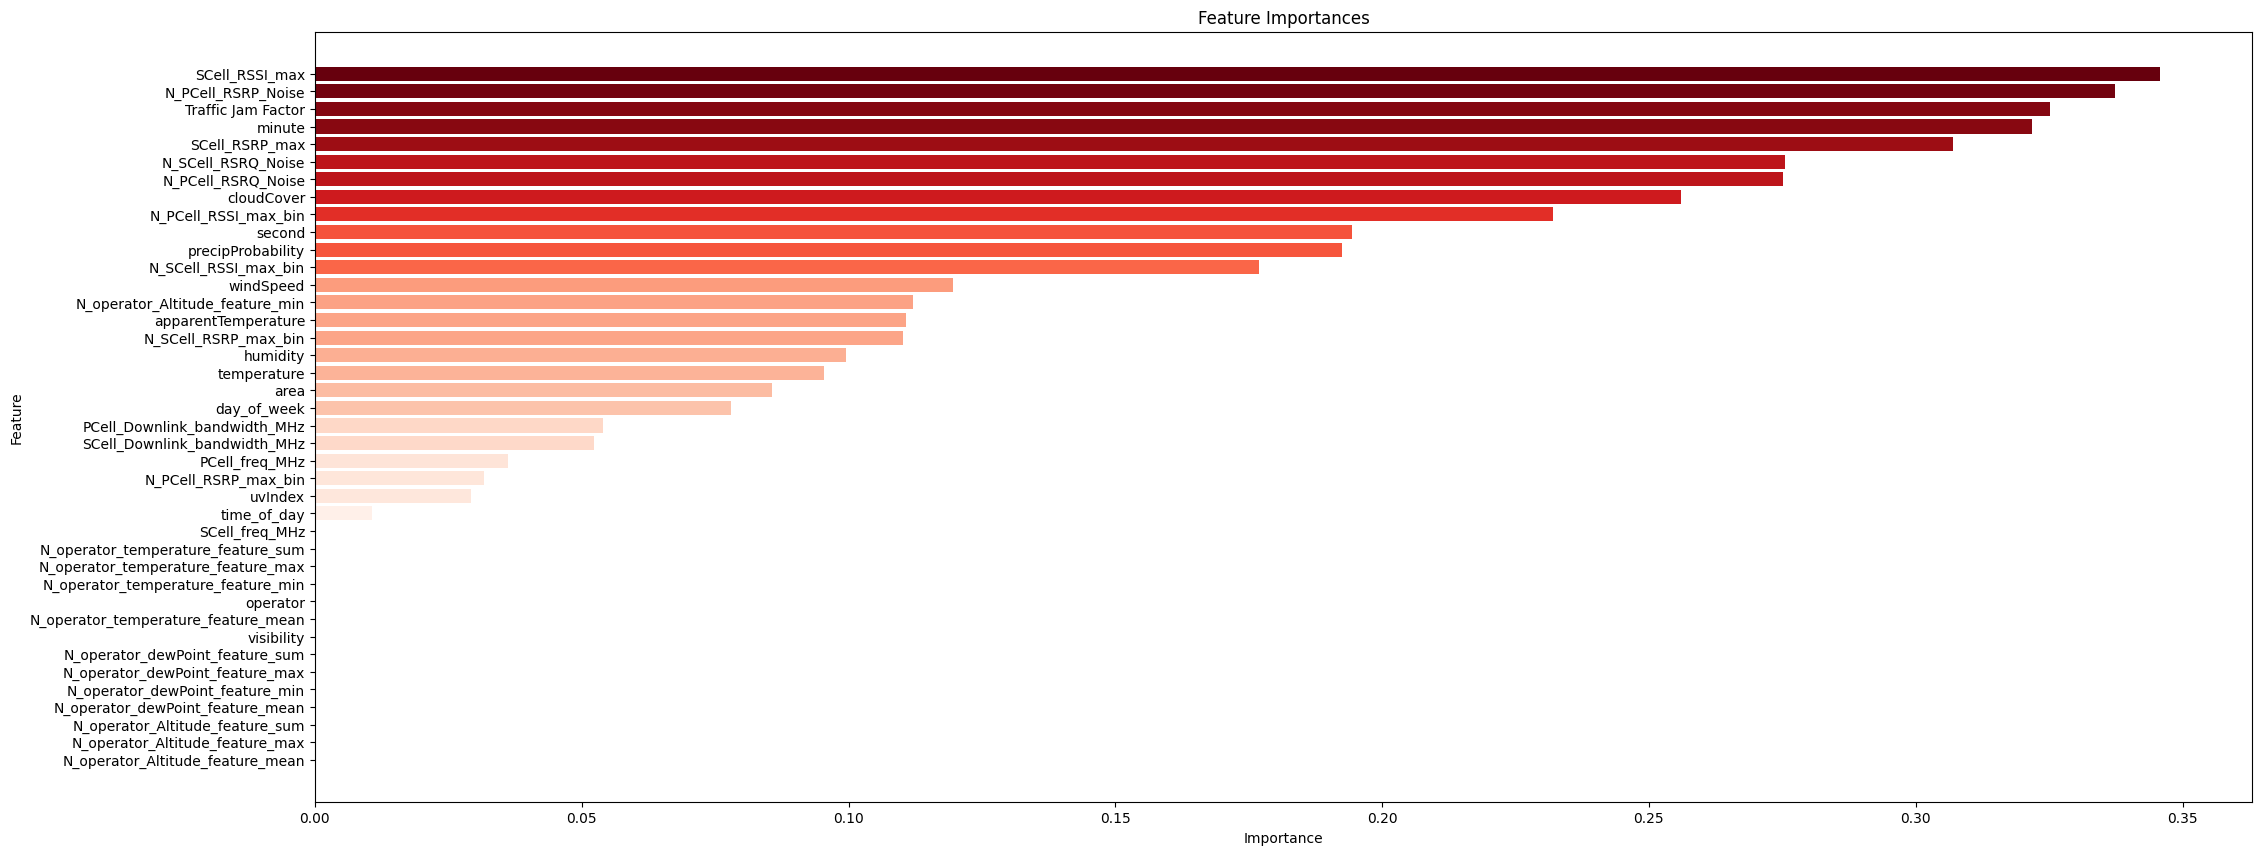

In [ ]:
Baseline.plot_features(n_features=40)